In [9]:
import subprocess
import pandas as pd
import json
import matplotlib.pyplot as plt

metadata = []
with open("bug_portfolio/metadata.jsonl", "r") as f:
    buffer = ""
    for line in f:
        line = line.strip()
        if not line:
            continue
        buffer += line
        if line.endswith("}"):
            try:
                metadata.append(json.loads(buffer))
            except json.JSONDecodeError:
                pass
            buffer = ""

bug_map = {item["name"]: item.get("bug_description", "No description provided") for item in metadata}
functions = [item["name"] for item in metadata]

# Create mapping from function name to bug description
bug_map = {item["name"]: item.get("bug_description", "No description provided") for item in metadata}
functions = [item["name"] for item in metadata]

print(functions)

['set_Right_most_Unset_Bit', 'find_Max', 'gold_mine_problem', 'check_Validity', 'bitonic_subsequence', 'binomial_Coeff', 'bell_Number', 'max_chain_length']


In [10]:
llm_found = {}
human_found = {}
for func in functions:
    print(f"\n=== Testing `{func}` ===")
    print(f"Bug Description: {bug_map[func]}")
    test_file = f"llm_tests/generated_tests/test_{func}.py"
    result = subprocess.run(["pytest", "-q", test_file],
                             capture_output=True, text=True)
    found = (result.returncode != 0)
    llm_found[func] = found
    status = "found" if found else "not found"
    print(f"LLM tests for `{func}`: Bug {status} (exit code {result.returncode})")

    test_file = f"human_tests/test_{func}.py"
    result = subprocess.run(["pytest", "-q", test_file],
                             capture_output=True, text=True)
    found = (result.returncode != 0)
    human_found[func] = found
    status = "found" if found else "not found"
    print(f"Human tests for `{func}`: Bug {status} (exit code {result.returncode})")



=== Testing `set_Right_most_Unset_Bit` ===
Bug Description: When n = 0, the function returns 0 instead of 1
LLM tests for `set_Right_most_Unset_Bit`: Bug found (exit code 1)
Human tests for `set_Right_most_Unset_Bit`: Bug found (exit code 1)

=== Testing `find_Max` ===
Bug Description: the condition if (arr[low] >= arr[mid]) should be if (arr[low] > arr[mid]), as using >= can cause incorrect recursion and miss the maximum element in certain cases.
LLM tests for `find_Max`: Bug not found (exit code 0)
Human tests for `find_Max`: Bug found (exit code 1)

=== Testing `gold_mine_problem` ===
Bug Description: The final answer calculation loop doesn't check for the last row's first element. ie loop is running till m-2
LLM tests for `gold_mine_problem`: Bug found (exit code 4)
Human tests for `gold_mine_problem`: Bug found (exit code 4)

=== Testing `check_Validity` ===
Bug Description: No description provided
LLM tests for `check_Validity`: Bug found (exit code 4)
Human tests for `check_Val

In [11]:
results = []
for func in functions:
    results.append({
        "Function": func,
        "LLM Found": "Yes" if llm_found.get(func, False) else "No",
        "Human Found": "Yes" if human_found.get(func, False) else "No"
    })

df = pd.DataFrame(results)



# Manually update any function’s results here:
# df.loc[df['Function'] == 'gold_mine_problem', 'LLM Found'] = 'No'
# df.loc[df['Function'] == 'set_Right_most_Unset_Bit', 'Human Found'] = 'Yes'
# Uncomment and edit as needed

# ---- Manual overrides go here ----
# df.loc[df['Function'] == 'gold_mine_problem', 'LLM Found'] = 'No'
# df.loc[df['Function'] == 'set_Right_most_Unset_Bit', 'Human Found'] = 'Yes'
# ----------------------------------

print("### Individual Test Results\n")
print(df.to_markdown(index=False))

### Individual Test Results

| Function                 | LLM Found   | Human Found   |
|:-------------------------|:------------|:--------------|
| set_Right_most_Unset_Bit | Yes         | Yes           |
| find_Max                 | No          | Yes           |
| gold_mine_problem        | Yes         | Yes           |
| check_Validity           | Yes         | Yes           |
| bitonic_subsequence      | Yes         | Yes           |
| binomial_Coeff           | Yes         | Yes           |
| bell_Number              | Yes         | Yes           |
| max_chain_length         | Yes         | No            |


In [12]:
only_llm = ((df["LLM Found"] == "Yes") & (df["Human Found"] == "No")).sum()
only_human = ((df["LLM Found"] == "No") & (df["Human Found"] == "Yes")).sum()
both = ((df["LLM Found"] == "Yes") & (df["Human Found"] == "Yes")).sum()
neither = ((df["LLM Found"] == "No") & (df["Human Found"] == "No")).sum()

scorecard = pd.DataFrame({
    "Metric": [
        "Bugs found only by LLM tests",
        "Bugs found only by Human properties",
        "Bugs found by both",
        "Bugs found by neither"
    ],
    "Count": [only_llm, only_human, both, neither]
})

print("\n\n### Final Scorecard\n")
print(scorecard.to_markdown(index=False))


# === STEP 4: Optional — Save both tables to CSV (for report) ===
df.to_csv("results_summary.csv", index=False)
scorecard.to_csv("final_scorecard.csv", index=False)




### Final Scorecard

| Metric                              |   Count |
|:------------------------------------|--------:|
| Bugs found only by LLM tests        |       1 |
| Bugs found only by Human properties |       1 |
| Bugs found by both                  |       6 |
| Bugs found by neither               |       0 |


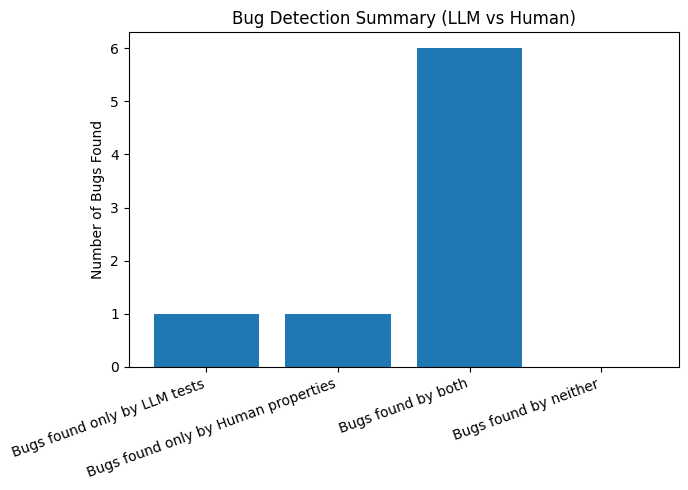

In [13]:
plt.figure(figsize=(7,5))
plt.bar(scorecard["Metric"], scorecard["Count"])
plt.title("Bug Detection Summary (LLM vs Human)")
plt.ylabel("Number of Bugs Found")
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.show()

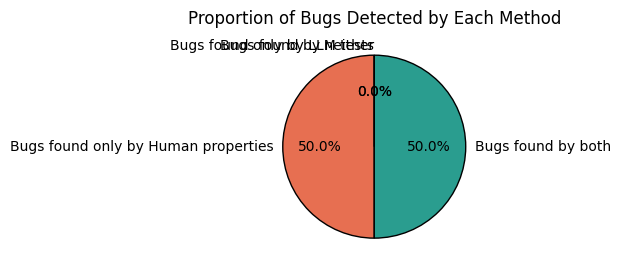

In [33]:
# === STEP 6: Graph 3 — Pie Chart for Scorecard Distribution ===
plt.figure(figsize=(6,6))
colors = ["#4B9CD3", "#E76F51", "#2A9D8F", "#E9C46A"]
plt.pie(
    scorecard["Count"],
    labels=scorecard["Metric"],
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    wedgeprops={"edgecolor": "black"}
)
plt.title("Proportion of Bugs Detected by Each Method")
plt.tight_layout()
plt.show()